In [1]:
import os
import sys

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import ColumnSelector
from mlxtend.regressor import StackingRegressor
from xgboost import XGBRegressor

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

from server.ml_models.betting_model import BettingModel, BettingModelData
from server.ml_models.match_model import MatchModel, MatchModelData
from server.ml_models.player_model import PlayerModel, PlayerModelData
from server.ml_models.all_model import AllModel, AllModelData
from src.model.metrics import measure_estimators, yearly_performance_scores
from src.model.charts import graph_cv_model_performance, graph_yearly_model_performance


np.random.seed(42)


class AveragingRegressor():
    def __init__(self, estimators):
        self.estimators = [(estimator(), data()) for estimator, data in estimators]

    def fit(self, train_years=(None, 2015)):
        for estimator, data in self.estimators:
            data.train_years = train_years
            estimator.fit(*data.train_data())
            
        return self
            
    def predict(self, test_years=(2016, 2016)):
        predictions = []

        for estimator, data in self.estimators:
            data.test_years = test_years
            X_test, _ = data.test_data()
            predictions.append(estimator.predict(X_test))
            
        # Player data has some extra rounds, because existing players contribute to a new team's first match's stats.
        # We drop them for consistency with other data sets.
        return pd.concat(predictions, axis=1).dropna().values.mean(axis=1)
    
    
def regression_accuracy(y, y_pred, **kwargs):  # pylint: disable=W0613
    correct_preds = ((y >= 0) & (y_pred >= 0)) | ((y <= 0) & (y_pred <= 0))
    return np.mean(correct_preds.astype(int))


class StackingRegressor():
    def __init__(self, estimators, meta_estimator):
        self.estimators = [(estimator(), data()) for estimator, data in estimators]
        self.all_data = AllModelData(train_years=(None, None), test_years=(None, None))
        self.meta_estimator = meta_estimator()

    def fit(self, train_years=(None, 2015)):
        predictions = []
        self.all_data.train_years = train_years
        _, y_all = self.all_data.train_data()

        for estimator, data in self.estimators:
            data.train_years = train_years
            X_train, y_train = data.train_data()
            estimator.fit(X_train, y_train)
            predictions.append(estimator.predict(X_train).rename(type(estimator).__name__))
            
        # Player data has some extra rounds, because existing players contribute to a new team's first match's stats.
        # We drop them for consistency with other data sets.
        X_all = pd.concat(predictions, axis=1).fillna(0).loc[y_all.index, :]
        self.meta_estimator.fit(X_all, y_all)
            
        return self
            
    def predict(self, test_years=(2016, 2016)):
        self.all_data.test_years = test_years
        predictions = []

        for estimator, data in self.estimators:
            data.test_years = test_years
            X_test, _ = data.test_data()
            predictions.append(estimator.predict(X_test).rename(type(estimator).__name__))

        X_all = pd.concat(predictions, axis=1).dropna()
            

        return self.meta_estimator.predict(X_all)

In [2]:
TRAIN_YEARS = (None, 2015)
TEST_YEARS = (2016, 2016)
ML_MODELS = [
    (BettingModel, BettingModelData, 'betting'),
    (MatchModel, MatchModelData, 'match'),
    (PlayerModel, PlayerModelData, 'player'),
    (AllModel, AllModelData, 'all'),
]

## Yearly performance compared to averaging predictions

In [3]:
# Get yearly scores from basic models

year_scores = []

for ml_model, ml_data, ml_name in ML_MODELS:
    data = ml_data(train_years=(None, None), test_years=(None, None))
    X, y = data.train_data()
    model = ml_model()
    
    year_scores.append(yearly_performance_scores([(ml_name, model, False)], X, y))

year_scores_df = pd.concat(year_scores)
year_scores_df

/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'player_id' is both 

,model,year,error,accuracy
0,betting,2011,29.582665,0.743590
1,betting,2012,29.745032,0.752427
2,betting,2013,26.358152,0.724638
3,betting,2014,27.916957,0.710145
4,betting,2015,30.110407,0.713592
5,betting,2016,29.074118,0.714976
0,match,2011,32.154488,0.720513
1,match,2012,30.641876,0.742718
2,match,2013,28.105106,0.688406
3,match,2014,31.245366,0.685990


In [4]:
# Get yearly scores from averaging ensemble

AVG_ML_MODELS = [
    (BettingModel, BettingModelData),
    (MatchModel, MatchModelData),
    (PlayerModel, PlayerModelData),
]

ensemble = AveragingRegressor(AVG_ML_MODELS)
all_data = AllModelData()
ensemble_scores = []

for year in range(2011, 2017):
    all_data.test_years = (year, year)
    ensemble.fit(train_years=(None, year - 1))
    
    y_pred = ensemble.predict(test_years=(year, year))
    _, y_test = all_data.test_data()
    
    ensemble_scores.append({
        'year': year,
        'model': 'average',
        'error': mean_absolute_error(y_test, y_pred),
        'accuracy': regression_accuracy(y_test, y_pred)
    })

ens_scores_df = pd.DataFrame(ensemble_scores)
ens_scores_df

/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(["player_id", "year"], group_keys=True)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'year' is both an index level and a column label.
Defau

,accuracy,error,model,year
0,0.769231,30.905084,average,2011
1,0.774272,29.257214,average,2012
2,0.698068,26.718730,average,2013
3,0.734300,28.959731,average,2014
4,0.713592,29.701776,average,2015
5,0.717391,29.124501,average,2016


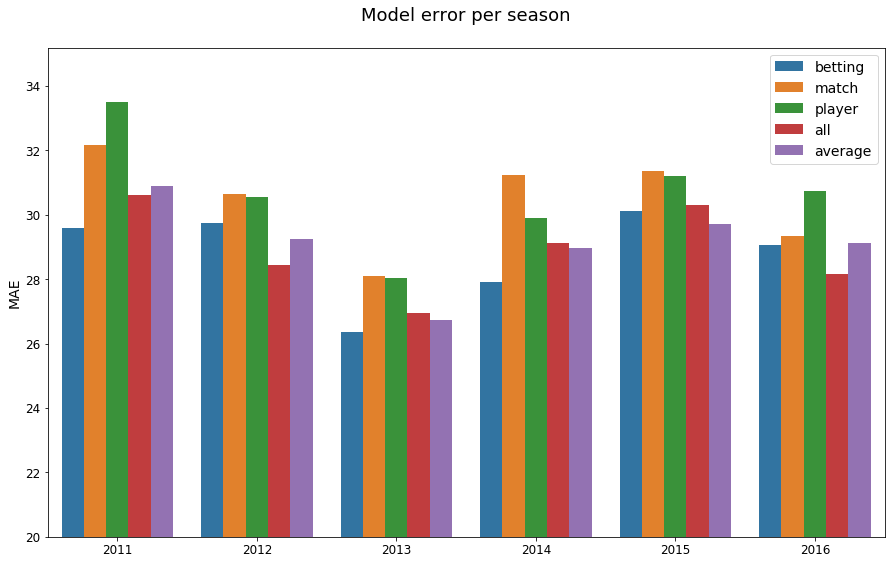

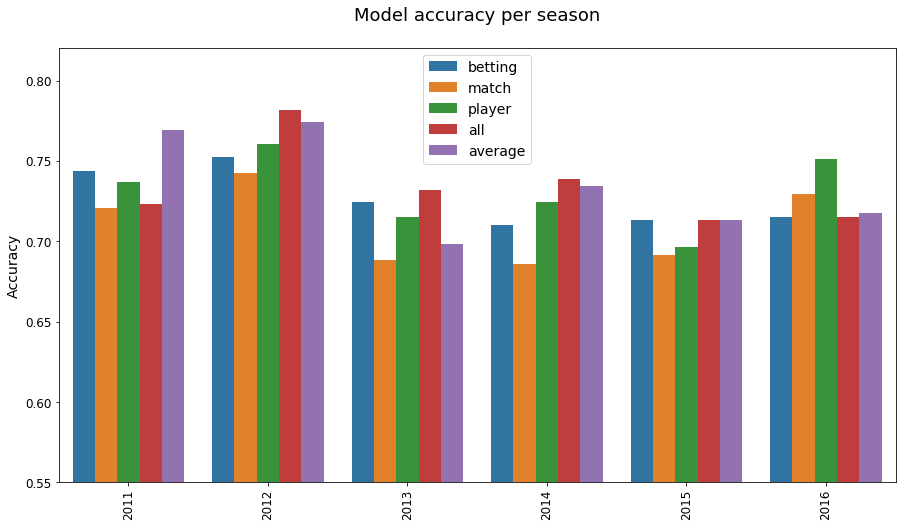

In [5]:
all_scores_df = pd.concat([year_scores_df, ens_scores_df], sort=True)

graph_yearly_model_performance(all_scores_df)

### Averaging individual model outputs has middling performance
Both betting and all data models tend to outperform the averaging model.

## Include all data model in average

In [6]:
ensemble.estimators.append((AllModel(), AllModelData()))

ensemble_scores = []

for year in range(2011, 2017):
    all_data.test_years = (year, year)
    ensemble.fit(train_years=(None, year - 1))
    
    y_pred = ensemble.predict(test_years=(year, year))
    _, y_test = all_data.test_data()
    
    ensemble_scores.append({
        'year': year,
        'model': 'average',
        'error': mean_absolute_error(y_test, y_pred),
        'accuracy': regression_accuracy(y_test, y_pred)
    })

ens_scores_df2 = pd.DataFrame(ensemble_scores)
ens_scores_df2

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(["player_id", "year"], group_keys=True)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'year' is both an index level and a column label.
Defau

,accuracy,error,model,year
0,0.746154,30.684081,average,2011
1,0.769417,28.926852,average,2012
2,0.717391,26.595336,average,2013
3,0.734300,28.936858,average,2014
4,0.720874,29.737909,average,2015
5,0.714976,28.732122,average,2016


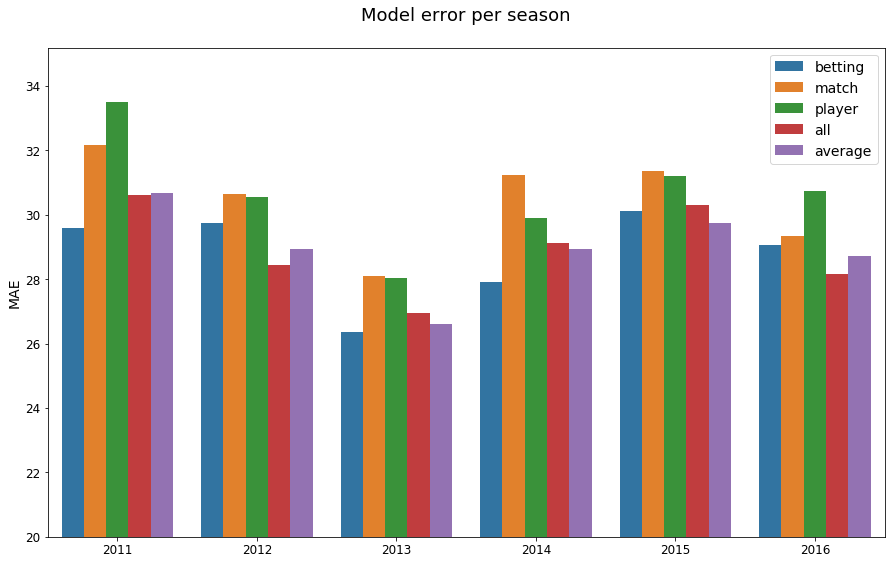

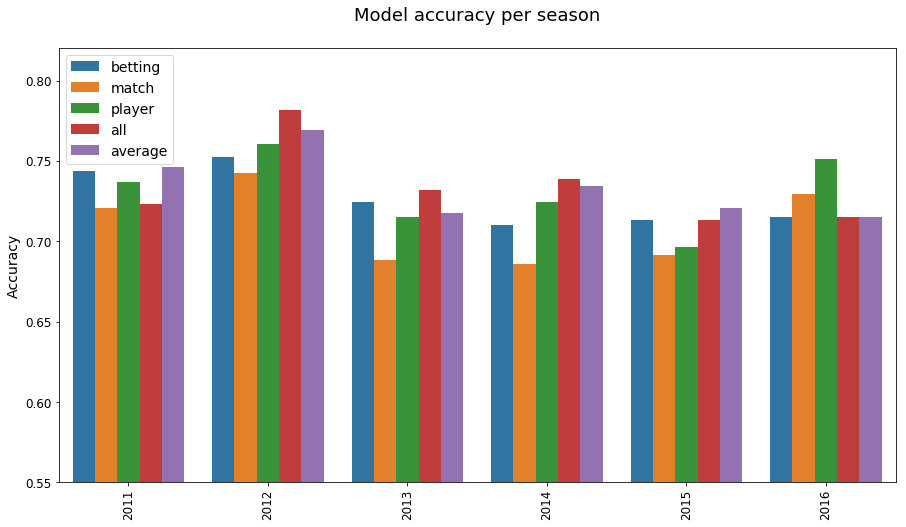

In [7]:
all_scores_df2 = pd.concat([year_scores_df, ens_scores_df2], sort=True)

graph_yearly_model_performance(all_scores_df2)

In [8]:
all_scores_df2.groupby('model').mean().loc[:, ['accuracy', 'error']]

,accuracy,error
model,,
all,0.734035,28.933044
average,0.733852,28.935526
betting,0.726561,28.797888
match,0.709807,30.475872
player,0.730923,30.657035


### Adding all data model into average improves performance
Betting model still has the best error, and all data model probably has the best overall performance, but the averaging model is close.

## Change averaging to meta estimator

In [9]:
ensemble.estimators.append((AllModel(), AllModelData()))

STACK_ML_MODELS = [
    (BettingModel, BettingModelData),
    (MatchModel, MatchModelData),
    (PlayerModel, PlayerModelData),
    (AllModel, AllModelData),
]

stack = StackingRegressor(STACK_ML_MODELS, XGBRegressor)
stack_scores = []

for year in range(2011, 2017):
    all_data.test_years = (year, year)
    stack.fit(train_years=(None, year - 1))
    
    y_pred = stack.predict(test_years=(year, year))
    _, y_test = stack.all_data.test_data()
    
    stack_scores.append({
        'year': year,
        'model': 'stack',
        'error': mean_absolute_error(y_test, y_pred),
        'accuracy': regression_accuracy(y_test, y_pred)
    })

stack_scores_df = pd.DataFrame(stack_scores)
stack_scores_df

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(["player_id", "year"], group_keys=True)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'year' is both an index level and a column label.
Defau

,accuracy,error,model,year
0,0.728205,30.059319,stack,2011
1,0.769417,28.717817,stack,2012
2,0.722222,26.470925,stack,2013
3,0.736715,29.695272,stack,2014
4,0.691748,30.471171,stack,2015
5,0.731884,29.142790,stack,2016


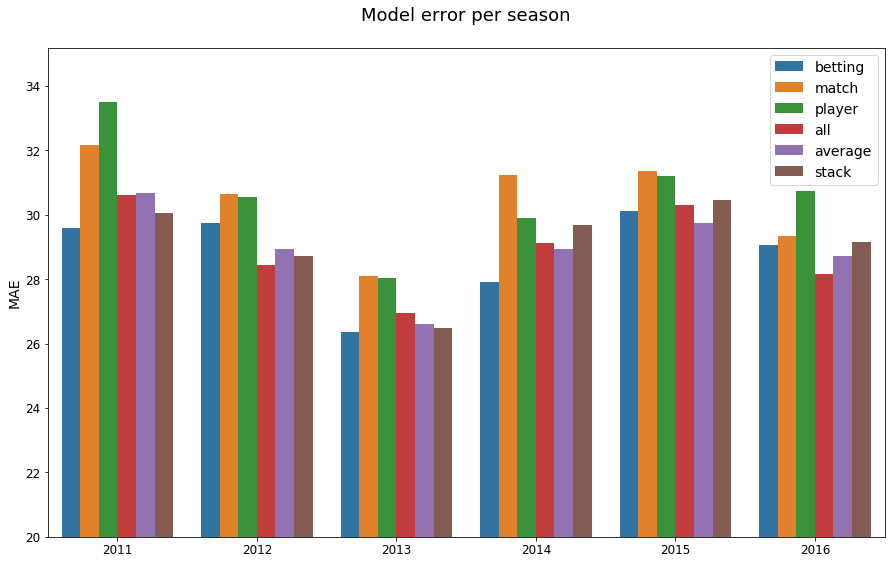

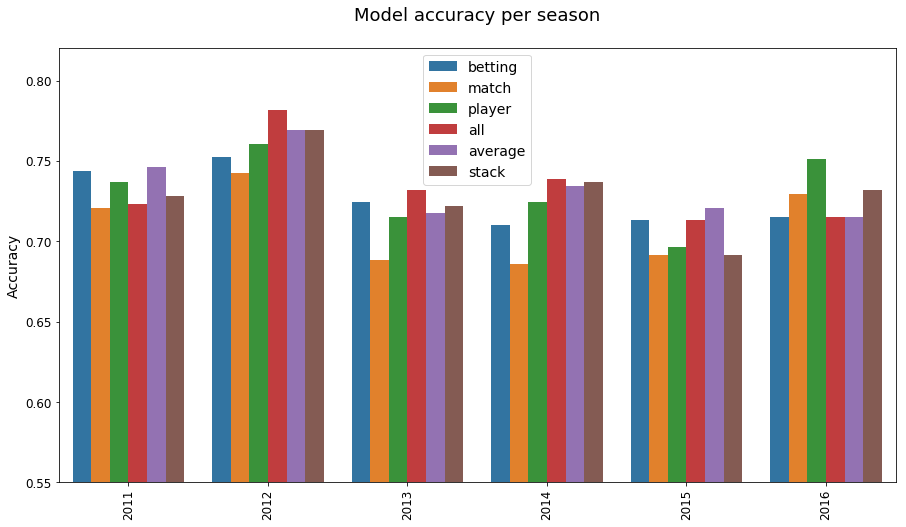

In [10]:
all_scores_df3 = pd.concat([all_scores_df2, stack_scores_df], sort=True)

graph_yearly_model_performance(all_scores_df3)

In [11]:
all_scores_df3.groupby('model').mean().loc[:, ['accuracy', 'error']]

,accuracy,error
model,,
all,0.734035,28.933044
average,0.733852,28.935526
betting,0.726561,28.797888
match,0.709807,30.475872
player,0.730923,30.657035
stack,0.730032,29.092882


### Averaging performs better than stacking with XGB